### Considered model: four-bar linkage (= two link manipulator + one link manipulator + rigid coupling)


This Notebook depends on symbtools >=0.2.5

→ `pip install --upgrade symbtools`





In [69]:
%load_ext ipydex.displaytools
%matplotlib inline

import sys
# to load assimulo under wsl2
sys.path.append('/home/kwrede/miniconda3/lib/python3.8/site-packages')
sys.path.append('/home/wredi/miniconda3/lib/python3.8/site-packages')

import os
import sympy as sp
import numpy as npy  # we need `np` later 
from sympy import sin, cos, pi
from sympy.interactive import printing

# using wredsen's symbtools fork (https://github.com/wredsen/symbtools @ DAE_statefeedback), assuming repos SA-Wrede and symbtools share the same parent directory
sys.path.append('../../symbtools/')
import symbtools as st
import symbtools.modeltools as mt
from symbtools.modeltools import Rz # Rotationsmatrix in the xy plane (c, -s; s, c)

import scipy.integrate as sc_integrate
from scipy.optimize import fmin
import matplotlib.pyplot as pl
from assimulo.solvers import ODASSL as SOLVER # Imports the solver ODASSL from Assimulo
from assimulo.problem import Overdetermined_Problem # Imports the problem formulation from Assimulo
import ipydex
plt = pl

printing.init_printing(1)

The ipydex.displaytools extension is already loaded. To reload it, use:
  %reload_ext ipydex.displaytools


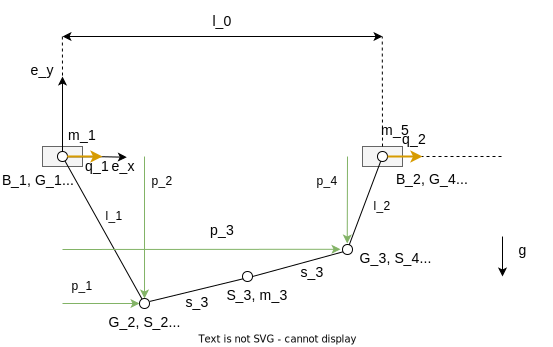

In [70]:
from IPython.display import Image
from IPython.core.display import SVG
SVG(filename='double_crane_cartesian_diagram.svg')

In [71]:
t = sp.Symbol('t')  # time variable

# coordinates
np = 4 # number of passive coordinates
nq = 2 # number of actuated coordinates
n = np + nq

pp = st.symb_vector("p1:{0}".format(np+1)) # vector of passive coordinates
qq = st.symb_vector("q1:{0}".format(nq+1)) # vector of actuated coordinates

# vector of control inputs
aa = st.symb_vector("a1:{0}".format(nq+1)) ##:T
# vector of all coordinates
ttheta = st.row_stack(pp, qq) ##:T
# vector of velocities 
tthetad = st.time_deriv(ttheta, ttheta) ##:T
# vector of accelerations
tthetadd = st.time_deriv(ttheta, ttheta, order=2) ##:T

st.make_global(ttheta, tthetad, tthetadd)

aa.T := [a₁  a₂]

---

ttheta.T := [p₁  p₂  p₃  p₄  q₁  q₂]

---

tthetad.T := [ṗ₁  ṗ₂  ṗ₃  ṗ₄  q̇₁  q̇₂]

---

tthetadd.T := [p̈₁  p̈₂  p̈₃  p̈₄  q̈₁  q̈₂]

---

In [72]:
# symbols for analytic equations
params = sp.symbols('s3, m1, m2, m3, m4, m5, J1, J2, J3, mc1b, mc2b d1, d4, l0, l1, l2, g')
st.make_global(params)

# symbols for control inputs
# ttau = sp.symbols('tau')
tau1, tau2, tau3 = ttau = st.symb_vector("tau1, tau2, tau3")


Specify the geometry (joints G and centers of masses S)

In [73]:
# unit vectors
ex = sp.Matrix([1, 0]) 
ey = sp.Matrix([0, 1]) 

# basis 1 and 2 (cart positions)
S1 = G1 = B1 = sp.Matrix([q1, 0]) ##:
S5 = G4 = B2 = sp.Matrix([l0 + q2, 0]) ##:

# joints 2 and 3 (load joints)
S2 = G2 = sp.Matrix([p1, p2]) ##:
S4 = G3 = sp.Matrix([p3, p4]) ##:

# center of mass of load
S3 = 1/2*(S2+S4) ##:

# Time derivatives of centers of masses
Sd1, Sd2, Sd3, Sd4, Sd5 = st.col_split(st.time_deriv(st.col_stack(S1, S2, S3, S4, S5), ttheta))

B1 := ⎡q₁⎤
⎢  ⎥
⎣0 ⎦

---

B2 := ⎡l₀ + q₂⎤
⎢       ⎥
⎣   0   ⎦

---

G2 := ⎡p₁⎤
⎢  ⎥
⎣p₂⎦

---

G3 := ⎡p₃⎤
⎢  ⎥
⎣p₄⎦

---

S3 := ⎡0.5⋅p₁ + 0.5⋅p₃⎤
⎢               ⎥
⎣0.5⋅p₂ + 0.5⋅p₄⎦

---

---

---

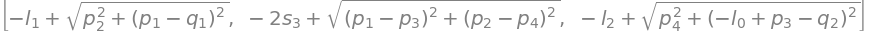

---

In [74]:
# kinetic energy
T1 = (m1/2 * Sd1.T*Sd1)[0] 
T2 = (m2/2 * Sd2.T*Sd2)[0]
T3 = (m3/2 * Sd3.T*Sd3)[0]
T4 = (m4/2 * Sd4.T*Sd4)[0]
T5 = (m5/2 * Sd5.T*Sd5)[0]

T = T1 + T2 + T3 + T4 + T5 ##:

# potential energy, for l1 <= l2
V = g*(m2*S2[1] + m3*S3[1] + m4*S4[1]) ##:

geometric_constraints = [sp.sqrt((p1-q1)**2 + p2**2) - l1, 
                         sp.sqrt((p1-p3)**2 + (p2-p4)**2) - 2*s3,
                         sp.sqrt((p3-l0-q2)**2 + p4**2) - l2] ##:

In [75]:
###### mu1, mu2 = mmu = st.symb_vector("mu1, mu2")

# dissipation included here! -d1*qdot1, -d4*qdot2 should be in control input function later
external_forces = [0 , 0, 0, 0, tau1, tau2]

# model generation with Lagragian Mechanics
mod = mt.generate_symbolic_model(T, V, ttheta, external_forces, constraints=geometric_constraints)


In [76]:
# implicit(=0) system equations 
mod.eqns

⎡          λ₁⋅p₁                   λ₁⋅q₁                      λ₂⋅p₁           
⎢- ───────────────────── + ───────────────────── - ───────────────────────────
⎢     __________________      __________________      ________________________
⎢    ╱   2            2      ╱   2            2      ╱          2            2
⎢  ╲╱  p₂  + (p₁ - q₁)     ╲╱  p₂  + (p₁ - q₁)     ╲╱  (p₁ - p₃)  + (p₂ - p₄) 
⎢                                                                             
⎢                              λ₁⋅p₂                      λ₂⋅p₂               
⎢    g⋅m₂ + 0.5⋅g⋅m₃ - ───────────────────── - ──────────────────────────── + 
⎢                         __________________      _________________________   
⎢                        ╱   2            2      ╱          2            2    
⎢                      ╲╱  p₂  + (p₁ - q₁)     ╲╱  (p₁ - p₃)  + (p₂ - p₄)     
⎢                                                                             
⎢                                   λ₂⋅(p₁ - p₃)    

### Creation of DAE System

Real Load has continuous mass distribution ($m_{ges}, J$), here it is replaced with a system of 3 masses ($m_2, m_3, m_4$) evenly spaced by $s_3$. The masses have to be calculated using the following relations:
\begin{align}
    m_{ges} &= m_2 + m_3 + m_4 = 0.557 \\
    m_2 &= m_4\\
    J &= m_2 s_3^2 + m_4 s_3^2 = 2 m_2 s_3^2 = 0.000221 \\
    \Rightarrow m_2 &= m_4 = \frac{J}{2 s_3^2} = 0.004911111 \\
    \Rightarrow m_3 &= m_{ges} - m_2 -m_4 = 0.547177778
\end{align}

In [77]:
parameter_values = list(dict(s3=0.15, m1=0.45, m2=0.004911111, m3=0.547177778, m4=0.004911111, m5=0.45, mc1b=39, mc2b=36.3, d1=9.76, d4=11.2, l0=0.5, l1=0.4, l2=0.4, g=9.81).items()) ##:
# tbd: J2, d1, d4

parameter_values := [('s3', 0.15),
 ('m1', 0.45),
 ('m2', 0.004911111),
 ('m3', 0.547177778),
 ('m4', 0.004911111),
 ('m5', 0.45),
 ('mc1b', 39),
 ('mc2b', 36.3),
 ('d1', 9.76),
 ('d4', 11.2),
 ('l0', 0.5),
 ('l1', 0.4),
 ('l2', 0.4),
 ('g', 9.81)]

---

#### Visualization of kinematics for debugging and placement of initial values

In [78]:
# matrix of joints
joints = sp.Matrix.hstack(G1, G2, G3, G4) ##:
joints = joints.subs(parameter_values)
# constraints equations (implicit) as vector
constraints = mod.constraints ##:
constraints = constraints.subs(parameter_values)

# numerical functions for joints and constraints
constraints_func = sp.lambdify(ttheta, constraints, modules="numpy")
joints_func = sp.lambdify(ttheta, joints, modules="numpy")

# cost function of constraints, theta_var: variable coordinates to be optimized, theta_const: constant coordinate (manipulated by slider later)
def constraint_cost(theta_var, theta_const):   
    err = constraints_func(theta_const[0], *theta_var, theta_const[1], theta_const[2])
    return err[0]**2 + err[1]**2 + err[2]**2 # squared error

joints := ⎡q₁  p₁  p₃  l₀ + q₂⎤
⎢                   ⎥
⎣0   p₂  p₄     0   ⎦

---

constraints := ⎡             __________________     ⎤
⎢            ╱   2            2      ⎥
⎢    -l₁ + ╲╱  p₂  + (p₁ - q₁)       ⎥
⎢                                    ⎥
⎢           _________________________⎥
⎢          ╱          2            2 ⎥
⎢-2⋅s₃ + ╲╱  (p₁ - p₃)  + (p₂ - p₄)  ⎥
⎢                                    ⎥
⎢          ________________________  ⎥
⎢         ╱   2                  2   ⎥
⎣ -l₂ + ╲╱  p₄  + (-l₀ + p₃ - q₂)    ⎦

---

In [79]:
%matplotlib inline

init_theta = []

from ipywidgets import interact
@interact(p1=(-1, 1.5, .1), q1=(-1, 1, .1), q2=(-1, 1, .1))
def plot_func(p1, q1, q2):
    res = fmin(constraint_cost, x0=[-0.4, 0.5, -0.4], args=([p1, q1, q2],), disp=0, ftol=1e-15)

    # dependent coordinates
    p2, p3, p4 = res
    jc = joint_coords = joints_func(p1, p2, p3, p4, q1, q2)

    plt.plot(jc[0, :], jc[1, :], "ok", ms=7)
    plt.plot(jc[0, :], jc[1, :], "b-")
    plt.axis("equal")
    plt.axis([-0.5, 1.4, -1.5, 0.5])
    
    init_theta[:] = [p1, p2, p3, p4, q1, q2]
    const_err = constraints_func(*init_theta)
    
    str_coords = ( f'Initial Values:\n'
                   f'p1: {p1}\n'
                   f'p2: {p2}\n'
                   f'p3: {p3}\n'
                   f'p4: {p4}\n'
                   f'q1: {q1}\n'
                   f'q2: {q2}\n'
                   f'error of constraints: \n {const_err} \n')
    print(str_coords)

interactive(children=(FloatSlider(value=0.20000000000000018, description='p1', max=1.5, min=-1.0), FloatSlider…

#### DAE system for simulation

##### Adding rope lengths as states

In [80]:
www = st.symb_vector("w1:{0}".format(5)) # vector of rope actuator lengths
wwwd = st.time_deriv(www, www)
wwwdd = st.time_deriv(www, www, order=2)
st.make_global(www, wwwd, wwwdd)
mod.tt = sp.Matrix(len(mod.tt)+1, 1, [*mod.tt, w3]) ##:
mod.ttd = sp.Matrix(len(mod.ttd )+1, 1, [*mod.ttd, wdot3]) ##:
mod.ttdd = sp.Matrix(len(mod.ttdd)+1, 1, [*mod.ttdd, wddot3]) ##:
mod.tau = sp.Matrix(len(mod.tau)+1, 1, [*mod.tau, tau3]) ##:

(mod.tt) := ⎡p₁⎤
⎢  ⎥
⎢p₂⎥
⎢  ⎥
⎢p₃⎥
⎢  ⎥
⎢p₄⎥
⎢  ⎥
⎢q₁⎥
⎢  ⎥
⎢q₂⎥
⎢  ⎥
⎣w₃⎦

---

(mod.ttd) := ⎡ṗ₁⎤
⎢  ⎥
⎢ṗ₂⎥
⎢  ⎥
⎢ṗ₃⎥
⎢  ⎥
⎢ṗ₄⎥
⎢  ⎥
⎢q̇₁⎥
⎢  ⎥
⎢q̇₂⎥
⎢  ⎥
⎣ẇ₃⎦

---

(mod.ttdd) := ⎡p̈₁⎤
⎢  ⎥
⎢p̈₂⎥
⎢  ⎥
⎢p̈₃⎥
⎢  ⎥
⎢p̈₄⎥
⎢  ⎥
⎢q̈₁⎥
⎢  ⎥
⎢q̈₂⎥
⎢  ⎥
⎣ẅ₃⎦

---

(mod.tau) := ⎡τ₁⎤
⎢  ⎥
⎢τ₂⎥
⎢  ⎥
⎣τ₃⎦

---

In [81]:
mod.constraints[0] = mod.constraints[0] - w3

In [82]:
mod.constraints

⎡                __________________  ⎤
⎢               ╱   2            2   ⎥
⎢  -l₁ - w₃ + ╲╱  p₂  + (p₁ - q₁)    ⎥
⎢                                    ⎥
⎢           _________________________⎥
⎢          ╱          2            2 ⎥
⎢-2⋅s₃ + ╲╱  (p₁ - p₃)  + (p₂ - p₄)  ⎥
⎢                                    ⎥
⎢          ________________________  ⎥
⎢         ╱   2                  2   ⎥
⎣ -l₂ + ╲╱  p₄  + (-l₀ + p₃ - q₂)    ⎦

In [83]:
# generate numerical DAE system from implicit system equations
dae = mod.calc_dae_eq(parameter_values)
dae.generate_eqns_funcs()

In [84]:
# degrees of freedom of DAE system
dae.ndof

In [85]:
# DAE's states and its derivatives
dae.yy ##:T
dae.yyd ##:T

(dae.yy).T := [p₁  p₂  p₃  p₄  q₁  q₂  w₃  ṗ₁  ṗ₂  ṗ₃  ṗ₄  q̇₁  q̇₂  ẇ₃  λ₁  λ₂  λ₃]

---

(dae.yyd).T := [ẏ₁  ẏ₂  ẏ₃  ẏ₄  ẏ₅  ẏ₆  ẏ₇  ẏ₈  ẏ₉  ẏ₁₀  ẏ₁₁  ẏ₁₂  ẏ₁₃  ẏ₁₄  ẏ₁₅  ẏ₁₆  ẏ₁₇]

---

In [86]:
# implicit equations of the DAE system
dae.eqns

⎡                                                                     -ṗ₁ + y
⎢                                                                             
⎢                                                                     -ṗ₂ + y
⎢                                                                             
⎢                                                                     -ṗ₃ + y
⎢                                                                             
⎢                                                                     -ṗ₄ + y
⎢                                                                             
⎢                                                                     -q̇₁ + y
⎢                                                                             
⎢                                                                     -q̇₂ + y
⎢                                                                             
⎢                                                   

In [25]:
dae.eqns[6:,:].jacobian(mod.tau)

⎡0   0 ⎤
⎢      ⎥
⎢0   0 ⎥
⎢      ⎥
⎢0   0 ⎥
⎢      ⎥
⎢0   0 ⎥
⎢      ⎥
⎢0   0 ⎥
⎢      ⎥
⎢-1  0 ⎥
⎢      ⎥
⎢0   -1⎥
⎢      ⎥
⎢0   0 ⎥
⎢      ⎥
⎢0   0 ⎥
⎢      ⎥
⎣0   0 ⎦

In [87]:
# control input vector of DAE system
dae.mod.tau

⎡τ₁⎤
⎢  ⎥
⎢τ₂⎥
⎢  ⎥
⎣τ₃⎦

In [88]:
# define closed loop (usage of yy) control function for input
# di*yy[] terms represent dissipation in carts
def new_input_func(yy, t):
    u1 = - d1.subs(parameter_values) * yy[10] + mc1b.subs(parameter_values)*yy[1]
    u2 = - d4.subs(parameter_values) * yy[11] + mc2b.subs(parameter_values)*yy[1] 
    u3 = 0
    return [u1, u2, u3]

# set as input of DAE system
dae.input_func = new_input_func ##:

(dae.input_func) := <function __main__.new_input_func(yy, t)>

---

In [90]:
dae.constraints_func(*init_theta, 0)

array([2.25726174e-08, 2.12635168e-08, 2.26519931e-08])

In [91]:
ttheta, ttheta_d = dae.calc_consistent_conf_vel(p1=init_theta[0], p2=init_theta[1], p3=init_theta[2], w3=0, _ftol=1e-9) ##:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 180
         Function evaluations: 332
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 76
         Function evaluations: 130


(ttheta, ttheta_d) := (array([ 2.00000000e-01, -3.46410188e-01,  4.95180037e-01, -2.92849509e-01,  4.59254296e-08,  2.67648686e-01,  0.00000000e+00]),
 array([0., 0., 0., 0., 0., 0., 0.]))

---

In [94]:
external_forces = [0 , 0, 0, 0, tau1, tau2, tau3]

In [103]:
len(st.concat_rows(dae.mod.tt, dae.mod.ttd, dae.mod.tau))

In [107]:
len(*npy.r_[npy.concatenate((ttheta, ttheta_d)), external_forces])

TypeError: len() takes exactly one argument (21 given)

In [102]:
A, b = dae.leqs_acc_lmd_func(*npy.r_[npy.concatenate((ttheta, ttheta_d)), external_forces])

AssertionError: 

In [47]:
dae.calc_consistent_accel_lmd((ttheta, ttheta_d), 0)

LinAlgError: Last 2 dimensions of the array must be square

In [89]:
# check error of constraints for initial values
dae.constraints_func(*init_theta, 0) ##:

# calculate consistent initial values from latest visualization
yy0, yyd0 = dae.calc_consistent_init_vals(p1=init_theta[0], p2=init_theta[1], p3=init_theta[2], w3=0, _ftol=1e-9) ##:

t0 = 0

# evaluation of implicit DAE System (should be almost 0 if initial values fulfill the model)
dae.model_func(t0, yy0, yyd0) ##:

# check if all values are almost zero (-> initial values fulfill the model)
assert npy.allclose(dae.model_func(t0, yy0, yyd0), 0)

(dae.constraints_func(*init_theta, 0)) := array([2.25726174e-08, 2.12635168e-08, 2.26519931e-08])

---

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 180
         Function evaluations: 332
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 76
         Function evaluations: 130


LinAlgError: Last 2 dimensions of the array must be square

In [24]:
# defining assimulo problem
model = Overdetermined_Problem(dae.model_func, yy0, yyd0, t0)
model.name = 'gantry crane'

# indicate which components of y are differential (1) and which are purely algebraic (0)
model.algvar = dae.diff_alg_vars ##:

# definition of simulation of DAE system with ODASSL solver
sim = SOLVER(model)
# sim.suppress_alg = True #Necessary to set to True for >1 index problem

# values <= 30 produce lots of output
sim.verbosity = 0

---

In [25]:
tfinal = 10.0        # Specify the final time
ncp = 500            # Number of communication points (number of return points)

# simulation of DAE system
tt_sol, yy_sol, yyd_sol = sim.simulate(tfinal, ncp) 

No initialization defined for the problem.
No finalization defined for the problem.
Final Run Statistics: gantry crane 

 Number of steps                           : 322
 Number of function evaluations            : 716
 Number of Jacobian evaluations            : 54
 Number of error test failures             : 1
 Number of nonlinear convergence failures  : 0

Solver options:

 Solver                  : ODASSL 
 Tolerances (absolute)   : [1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e+07 1.e+07 1.e+07]
 Tolerances (relative)   : 1e-06

Simulation interval    : 0.0 - 10.0 seconds.
Elapsed simulation time: 40.843215250000014 seconds.


In [26]:
# trajectories of coordinates and its velocities
ttheta_sol = yy_sol[:, :mod.dae.ntt]
ttheta_d_sol = yy_sol[:, mod.dae.ntt:mod.dae.ntt*2]

Text(0.5, 1.0, 'dot theta')

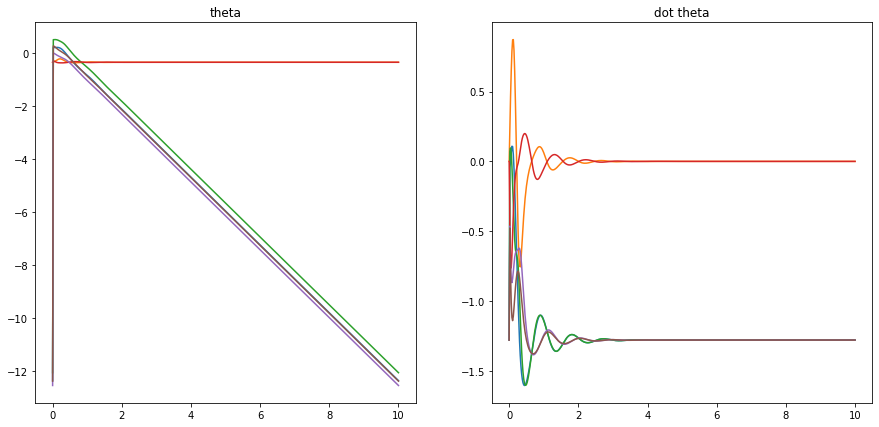

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7)); plt.sca(ax1)

ax1.plot(tt_sol, ttheta_sol)
ax1.set_title("theta")

ax2.plot(tt_sol, ttheta_d_sol)
ax2.set_title("dot theta")

####  Visualization and Animation of simulation solution

In [28]:
joint_pos_expr = st.col_stack(G1, G2, G3, G4).subs(parameter_values) ##:
joint_pos_func = st.expr_to_func(mod.tt, joint_pos_expr, keep_shape=True)

joint_pos_expr := ⎡q₁  p₁  p₃  q₂ + 0.5⎤
⎢                    ⎥
⎣0   p₂  p₄     0    ⎦

---

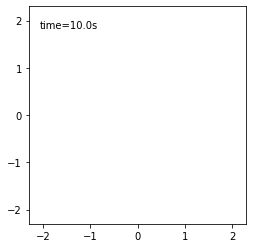

In [29]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = pl.figure() 
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2.3,2.3), ylim=(-2.3,2.3))
ax.set_aspect('equal')

line, = ax.plot([],[],'o-', lw=2)
time_template = 'time=%.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
dt = tt_sol[1] - tt_sol[0]


def init():
    line.set_data([],[])
    time_text.set_text('')
    return line, time_text

l1 =1.0

def animate(i):
    xx, yy = joint_pos_func(*ttheta_sol[i, :])
    
    line.set_data(xx,yy)
    time_text.set_text(time_template%(i*dt))
    
    return line, time_text


ani = animation.FuncAnimation(fig, animate, range(ttheta_sol.shape[0]), interval=tt_sol[-1]*3, blit=True, init_func=init)


# this animation is nice but results in a big notebook file which is unwanted for publication in the repo
HTML(ani.to_jshtml())





*Preliminary Conclusion*

→ Behavior looks more or less realistic - up to the configurations where $p_1$ is an integer multiple of $\pi$ (joint is fully streched or fully bended). Probably there are singularities.

#### Save animation

In [26]:
# this might need to be adapted on other systems

plt.rcParams["animation.codec"] = "libvpx-vp9"  # codec for webm
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
writer = animation.FFMpegWriter(fps=30)
ani.save("gantry_crane.webm", writer=writer)

In [27]:
%%HTML
<video width="320" height="240" controls>
  <source src="gantry_crane.webm" type="video/webm">
</video>